# Generative Adversarial Networks
So far, all the models we have worked with except the VAE have been discriminative models. This means that they are simply trying to predit something about our existing dataset. Sometimes, we would not like to discriminate but generate new examples of the data as in the case of video or image generation. Technically, this is the problem of modelling a probability distribution which we have samples of.

One approach which implicitly models the distribution, the work of Ian Goodfellow, has been enjoying great success - producing images indistinguishable from the types of examples on which it was trained. GANs take a game-theoretic approach, pitting two networks against eachother - the discriminator and the generator. The job of the generator is to produce images which are indistinguishable from the training set from latent variables while the job of the discriminator is to catch out the generator and discriminate real data from generated data. Initially they will both be terrible at their jobs but as the discriminator gets better, the generator is forced to get better to fool it and vice-versa. This loop continues until they are both excellent at their jobs and the generator can now be used to produce very realistic data points.

![](GAN.png)

An analogy often used to describe this is the detective and the forger. The generator is like a forger who is trying to produce paintings indistinguishable from other famous paintings by an artists while the discriminator is like a detective who is trying to catch the forger out. As the detective gets better at catching the generator out, the generator is forced to improve to fool the detective.

## Implementation
We will be training a GAN on the fashion MNIST dataset so we will be able to produce images of items of clothing which look like they came from the original dataset.

We begin by importing the appropriate libraries.

In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt    

We load our dataset into a pytorch dataloader which we will use later to produce random batches of samples from our dataset.

In [2]:
batch_size = 100

train_data = datasets.FashionMNIST(root='fashiondata/',
                                 transform=transforms.ToTensor(),
                                 train=True,
                                 download=True
                                 )

train_samples = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True
                                            )



Define the NN model we will be using for our discriminator. It takes in the 28x28 image and performs convolutions followed by one fully connected layer to output the probability of the data point being real and not generated.

In [3]:
class discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1) #1x28x28-> 64x14x14
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) #64x14x14-> 128x7x7
        self.dense1 = torch.nn.Linear(128*7*7, 1)

        self.bn1 = torch.nn.BatchNorm2d(64)
        self.bn2 = torch.nn.BatchNorm2d(128)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x))).view(-1, 128*7*7)
        x = F.sigmoid(self.dense1(x))
        return x

Define the NN model for the generator. This takes in a latent vector of size 128 and performs fully connected layers followed by transpose-convolutions to output us a 28x28 image.

In [4]:
class generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(128, 256)
        self.dense2 = torch.nn.Linear(256, 1024)
        self.dense3 = torch.nn.Linear(1024, 128*7*7)
        self.uconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) #128x7x7 -> 64x14x14
        self.uconv2 = torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1) #64x14x14 -> 1x28x28

        self.bn1 = torch.nn.BatchNorm1d(256)
        self.bn2 = torch.nn.BatchNorm1d(1024)
        self.bn3 = torch.nn.BatchNorm1d(128*7*7)
        self.bn4 = torch.nn.BatchNorm2d(64)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.dense1(x)))
        x = F.relu(self.bn2(self.dense2(x)))
        x = F.relu(self.bn3(self.dense3(x))).view(-1, 128, 7, 7)
        x = F.relu(self.bn4(self.uconv1(x)))
        x = F.sigmoid(self.uconv2(x))
        return x

We instantiate our models from the classes we define and their optimizers

<IPython.core.display.Javascript object>


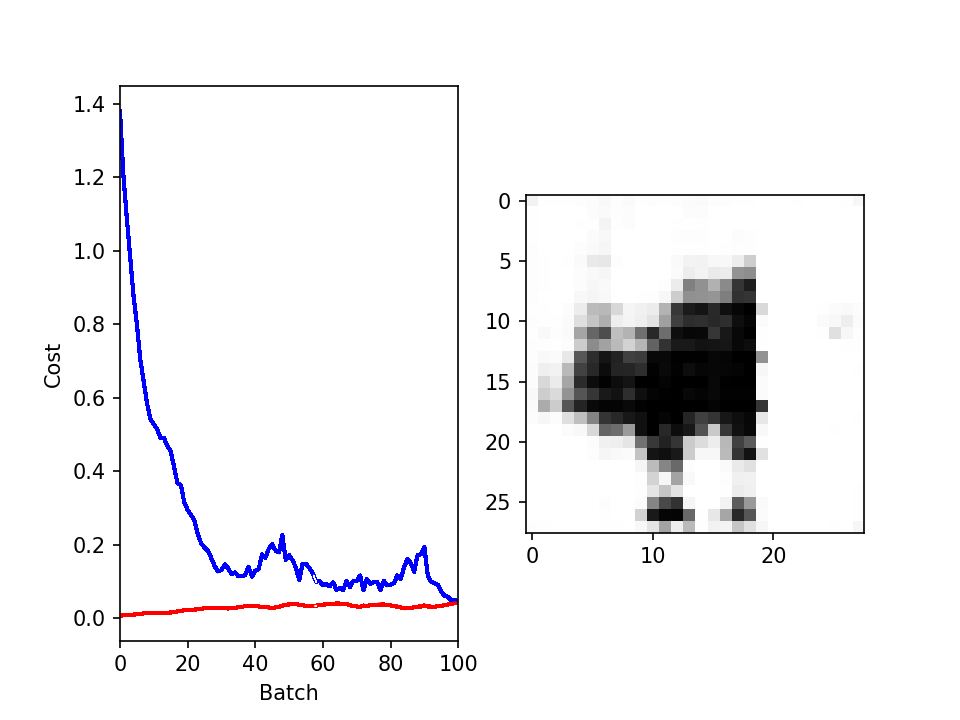

In [5]:
#instantiate model
d = discriminator()
g = generator()

#training hyperparameters
epochs = 100
dlr = 0.0003
glr = 0.0003

d_optimizer = torch.optim.Adam(d.parameters(), lr=dlr)
g_optimizer = torch.optim.Adam(g.parameters(), lr=glr)

dcosts = []
gcosts = []
plt.ion()
fig = plt.figure()
loss_ax = fig.add_subplot(121)
loss_ax.set_xlabel('Batch')
loss_ax.set_ylabel('Cost')
loss_ax.set_ylim(0, 0.2)
generated_img = fig.add_subplot(122)
plt.show()

We define the training loop. For every batch of training data that we look at, we get the generator to produce an equally sized batch of generated images. We then get the discriminator to make predictions on both sets and calulate the cost for both networks before calculating the gradients and training each one in turn.

In [ ]:
def train(epochs, glr, dlr):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        
        #iteratre over mini-batches
        for batch_idx, (real_images, _ ) in enumerate(train_samples):

            z = torch.randn(batch_size, 128) # generate random latent variable to generate images from
            generated_images = g.forward(z)  # generate images

            gen_pred = d.forward(generated_images)      # prediction of discriminator on generated batch
            real_pred = d.forward(real_images)          # prediction of discriminator on real batch

            dcost = -torch.sum(torch.log(real_pred)) - torch.sum(torch.log(1-gen_pred)) #cost of discriminator
            gcost = -torch.sum(torch.log(gen_pred))/batch_size #cost of generator
            
            #train discriminator
            d_optimizer.zero_grad()
            dcost.backward(retain_graph=True) # retain the computational graph so we can train generator after
            d_optimizer.step()
            
            #train generator
            g_optimizer.zero_grad()
            gcost.backward()
            g_optimizer.step()

            # give us an example of a generated image after every 10000 images produced
            if batch_idx * batch_size % 1000 == 0:
                g.eval() #put in evaluation mode
                noise_input = torch.randn(1, 128)
                generated_image = g.forward(noise_input)
            
                generated_img.imshow(generated_image.detach().squeeze(), cmap='gray_r')
                g.train() # put back into training mode


            dcost /= batch_size
            gcost /= batch_size

            print('Epoch: ', epoch, 'Batch idx:', batch_idx, '\tDisciminator cost: ', dcost.item(), '\tGenerator cost: ', gcost.item())
                
            dcosts.append(dcost)
            gcosts.append(gcost)

            loss_ax.plot(dcosts, 'b')
            loss_ax.plot(gcosts, 'r')

            fig.canvas.draw()

train(epochs, glr, dlr)

/home/ice/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  0 Batch idx: 0 	Disciminator cost:  0.15785743296146393 	Generator cost:  0.03806668892502785
Epoch:  0 Batch idx: 1 	Disciminator cost:  0.13835382461547852 	Generator cost:  0.03799670189619064
Epoch:  0 Batch idx: 2 	Disciminator cost:  0.1035105511546135 	Generator cost:  0.036350954324007034
Epoch:  0 Batch idx: 3 	Disciminator cost:  0.14821884036064148 	Generator cost:  0.03538254648447037
Epoch:  0 Batch idx: 4 	Disciminator cost:  0.14725765585899353 	Generator cost:  0.03355025872588158
Epoch:  0 Batch idx: 5 	Disciminator cost:  0.1373463124036789 	Generator cost:  0.03399433195590973
Epoch:  0 Batch idx: 6 	Disciminator cost:  0.12209533900022507 	Generator cost:  0.03354616090655327
Epoch:  0 Batch idx: 7 	Disciminator cost:  0.09891639649868011 	Generator cost:  0.03418406844139099
Epoch:  0 Batch idx: 8 	Disciminator cost:  0.10104179382324219 	Generator cost:  0.03547995164990425
Epoch:  0 Batch idx: 9 	Disciminator cost:  0.09003060311079025 	Generator cost:  0

Epoch:  0 Batch idx: 80 	Disciminator cost:  0.09285931289196014 	Generator cost:  0.031160293146967888
Epoch:  0 Batch idx: 81 	Disciminator cost:  0.09279023855924606 	Generator cost:  0.03095155954360962
Epoch:  0 Batch idx: 82 	Disciminator cost:  0.12179252505302429 	Generator cost:  0.031932562589645386
Epoch:  0 Batch idx: 83 	Disciminator cost:  0.09033500403165817 	Generator cost:  0.03370688110589981
Epoch:  0 Batch idx: 84 	Disciminator cost:  0.12505857646465302 	Generator cost:  0.03395739197731018
Epoch:  0 Batch idx: 85 	Disciminator cost:  0.13277918100357056 	Generator cost:  0.030654199421405792
Epoch:  0 Batch idx: 86 	Disciminator cost:  0.16477639973163605 	Generator cost:  0.029863936826586723
Epoch:  0 Batch idx: 87 	Disciminator cost:  0.17071130871772766 	Generator cost:  0.025616290047764778
Epoch:  0 Batch idx: 88 	Disciminator cost:  0.1717391461133957 	Generator cost:  0.027649682015180588
Epoch:  0 Batch idx: 89 	Disciminator cost:  0.1704443395137787 	Gen

Epoch:  0 Batch idx: 159 	Disciminator cost:  0.13471126556396484 	Generator cost:  0.032660141587257385
Epoch:  0 Batch idx: 160 	Disciminator cost:  0.11578378826379776 	Generator cost:  0.029656851664185524
Epoch:  0 Batch idx: 161 	Disciminator cost:  0.14954505860805511 	Generator cost:  0.027738843113183975
Epoch:  0 Batch idx: 162 	Disciminator cost:  0.1664135754108429 	Generator cost:  0.026193544268608093
Epoch:  0 Batch idx: 163 	Disciminator cost:  0.12388162314891815 	Generator cost:  0.02937142178416252
Epoch:  0 Batch idx: 164 	Disciminator cost:  0.15592749416828156 	Generator cost:  0.03149617090821266
Epoch:  0 Batch idx: 165 	Disciminator cost:  0.15324948728084564 	Generator cost:  0.0320928618311882
Epoch:  0 Batch idx: 166 	Disciminator cost:  0.18602731823921204 	Generator cost:  0.02995116263628006
Epoch:  0 Batch idx: 167 	Disciminator cost:  0.15577054023742676 	Generator cost:  0.02704344317317009
Epoch:  0 Batch idx: 168 	Disciminator cost:  0.16737844049930

Epoch:  0 Batch idx: 238 	Disciminator cost:  0.19609130918979645 	Generator cost:  0.025247838348150253
Epoch:  0 Batch idx: 239 	Disciminator cost:  0.2055274248123169 	Generator cost:  0.02522050403058529
Epoch:  0 Batch idx: 240 	Disciminator cost:  0.1776021420955658 	Generator cost:  0.029147863388061523
Epoch:  0 Batch idx: 241 	Disciminator cost:  0.16801616549491882 	Generator cost:  0.03184181824326515
Epoch:  0 Batch idx: 242 	Disciminator cost:  0.20985835790634155 	Generator cost:  0.03348170220851898
Epoch:  0 Batch idx: 243 	Disciminator cost:  0.17364944517612457 	Generator cost:  0.03400849550962448
Epoch:  0 Batch idx: 244 	Disciminator cost:  0.1606414020061493 	Generator cost:  0.030083730816841125
Epoch:  0 Batch idx: 245 	Disciminator cost:  0.13788661360740662 	Generator cost:  0.028309280052781105
Epoch:  0 Batch idx: 246 	Disciminator cost:  0.15833045542240143 	Generator cost:  0.028110845014452934
Epoch:  0 Batch idx: 247 	Disciminator cost:  0.14957132935523

Epoch:  0 Batch idx: 317 	Disciminator cost:  0.3010128140449524 	Generator cost:  0.025770852342247963
Epoch:  0 Batch idx: 318 	Disciminator cost:  0.24817030131816864 	Generator cost:  0.025543127208948135
Epoch:  0 Batch idx: 319 	Disciminator cost:  0.25341057777404785 	Generator cost:  0.024403544142842293
Epoch:  0 Batch idx: 320 	Disciminator cost:  0.2543383836746216 	Generator cost:  0.024243326857686043
Epoch:  0 Batch idx: 321 	Disciminator cost:  0.281157910823822 	Generator cost:  0.02520749159157276
Epoch:  0 Batch idx: 322 	Disciminator cost:  0.22213402390480042 	Generator cost:  0.025794852524995804
Epoch:  0 Batch idx: 323 	Disciminator cost:  0.17933012545108795 	Generator cost:  0.027755243703722954
Epoch:  0 Batch idx: 324 	Disciminator cost:  0.233395054936409 	Generator cost:  0.030855681747198105
Epoch:  0 Batch idx: 325 	Disciminator cost:  0.26678940653800964 	Generator cost:  0.028039641678333282
Epoch:  0 Batch idx: 326 	Disciminator cost:  0.20286785066127

Epoch:  0 Batch idx: 396 	Disciminator cost:  0.3118551969528198 	Generator cost:  0.026899956166744232
Epoch:  0 Batch idx: 397 	Disciminator cost:  0.26780664920806885 	Generator cost:  0.0252943467348814
Epoch:  0 Batch idx: 398 	Disciminator cost:  0.3424498438835144 	Generator cost:  0.02328263223171234
Epoch:  0 Batch idx: 399 	Disciminator cost:  0.3500698208808899 	Generator cost:  0.019773952662944794
Epoch:  0 Batch idx: 400 	Disciminator cost:  0.37004637718200684 	Generator cost:  0.019513724371790886
Epoch:  0 Batch idx: 401 	Disciminator cost:  0.36090773344039917 	Generator cost:  0.021000586450099945
Epoch:  0 Batch idx: 402 	Disciminator cost:  0.37677818536758423 	Generator cost:  0.025097252801060677
Epoch:  0 Batch idx: 403 	Disciminator cost:  0.34221121668815613 	Generator cost:  0.02537107653915882
Epoch:  0 Batch idx: 404 	Disciminator cost:  0.39774972200393677 	Generator cost:  0.02292848378419876
Epoch:  0 Batch idx: 405 	Disciminator cost:  0.378258049488067

Epoch:  0 Batch idx: 475 	Disciminator cost:  0.24066515266895294 	Generator cost:  0.02989991381764412
Epoch:  0 Batch idx: 476 	Disciminator cost:  0.23608814179897308 	Generator cost:  0.03460773080587387
Epoch:  0 Batch idx: 477 	Disciminator cost:  0.2883172333240509 	Generator cost:  0.030220873653888702
Epoch:  0 Batch idx: 478 	Disciminator cost:  0.23750202357769012 	Generator cost:  0.02728600986301899
Epoch:  0 Batch idx: 479 	Disciminator cost:  0.29266220331192017 	Generator cost:  0.022512102499604225
Epoch:  0 Batch idx: 480 	Disciminator cost:  0.2204868346452713 	Generator cost:  0.022168761119246483
Epoch:  0 Batch idx: 481 	Disciminator cost:  0.20918621122837067 	Generator cost:  0.026386838406324387
Epoch:  0 Batch idx: 482 	Disciminator cost:  0.17915557324886322 	Generator cost:  0.029691465198993683
Epoch:  0 Batch idx: 483 	Disciminator cost:  0.1373041868209839 	Generator cost:  0.03344503417611122
Epoch:  0 Batch idx: 484 	Disciminator cost:  0.15840224921703

Epoch:  0 Batch idx: 554 	Disciminator cost:  0.10854066908359528 	Generator cost:  0.035455841571092606
Epoch:  0 Batch idx: 555 	Disciminator cost:  0.09541512280702591 	Generator cost:  0.033692967146635056
Epoch:  0 Batch idx: 556 	Disciminator cost:  0.14754751324653625 	Generator cost:  0.030484743416309357
Epoch:  0 Batch idx: 557 	Disciminator cost:  0.09914377331733704 	Generator cost:  0.03560500964522362
Epoch:  0 Batch idx: 558 	Disciminator cost:  0.097757488489151 	Generator cost:  0.031262874603271484
Epoch:  0 Batch idx: 559 	Disciminator cost:  0.11238548159599304 	Generator cost:  0.03371453657746315
Epoch:  0 Batch idx: 560 	Disciminator cost:  0.16988220810890198 	Generator cost:  0.03252733126282692
Epoch:  0 Batch idx: 561 	Disciminator cost:  0.13870973885059357 	Generator cost:  0.03236626833677292
Epoch:  0 Batch idx: 562 	Disciminator cost:  0.12490879744291306 	Generator cost:  0.03199586272239685
Epoch:  0 Batch idx: 563 	Disciminator cost:  0.14019824564456

In [ ]:
z = torch.randn(batch_size, 128) #generate random latent variable to generate images
im = g.forward(z) #generate images
plt.imshow(im)
